# Day 5  | First week task

Lets put our knowledge into action by tackling following tasks: 


- Load time lapse fluorescence data from Matlab file "task1.mat" that is in the main course folder. Data are stored in two matrices: *x_norm* contains trajectories and *t* is a time vector

- Plot (with labels) example cell tracetories | Tip: transpose the loaded data to get first dimension the same

- Find peaks in each trajectories usin scipy library functions | Tip: Search for suitable functions in scipy manual

- Calculate amplitude and period of oscillations | Tip: the period of oscillation is a distance between peaks in a single cell trajectory

- Draw histograms of period distribution

- Plot amplitude vs period with labels 

- Select ten cell trajectiories with the smallest periods and plot those as a heat map 

- Perform frequency analysis using FFT Fourier transformation and identify a dominant frequency in the signal


In [108]:
#import necessary tools, please add yourself here whatever you think you might need to solve the task

#basics
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plotter
from scipy.fftpack import fft
from scipy.signal import find_peaks


data = sio.loadmat('./task1.mat')

x = np.transpose(data['x_norm'])
time = np.transpose(data['t'])


In [109]:
# removing any possible nan before doing anything else
x_not_nan = np.nan_to_num(x) # replace nan with 0

In [110]:
def plot_example_cell_trajectories(x, time, num_cells):
    
    for i in range(num_cells):
        plotter.plot(time, x[:, i], linestyle = '--', label = 'Cell '+str(i))
    plotter.title('First {} cell trajectories'.format(num_cells))
    plotter.ylabel('fluorescence (a.u.)')
    plotter.xlabel('time (min)')
    plotter.legend();

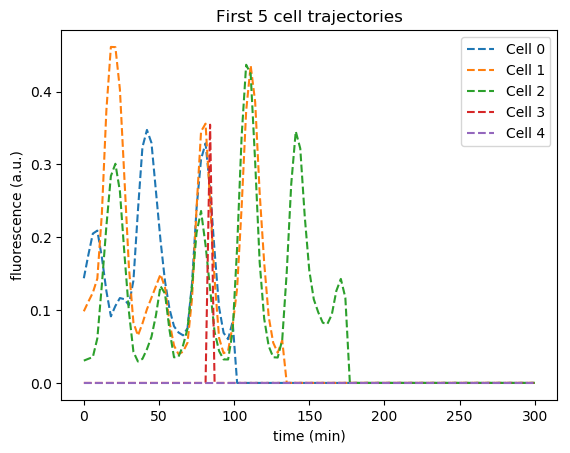

In [111]:
plot_example_cell_trajectories(x_not_nan, time, 5)

In [112]:
def find_all_peaks(x):
    peak_indexes = {} # cell number : array of peaks' indexes
    for cell in range(x.shape[1]): # for every cell
        peaks = find_peaks(x[:, cell])[0] # storing the array of indexes
        peak_indexes[cell] = peaks # storing it in the dictionary
    return peak_indexes
        

peak_indexes = find_all_peaks(x_not_nan) # calling the function

In [113]:
def mean_amplitudes(x, peak_indexes):
    # numpy array to store the mean amplitudes:
    mean_amp = np.zeros(x.shape[1]) 
    # calculating the mean amplitude for each cell:
    for cell in range(x.shape[1]): # for every cell
        cell_peaks_indexes = peak_indexes[cell] # array of indexes
        if cell_peaks_indexes.size != 0: # if there are any peaks
            amplitudes = x[cell_peaks_indexes, cell]
            mean_amplitude = np.mean(amplitudes)
            mean_amp[cell] = mean_amplitude # storing it
        # if there are no peaks, there is no maximum value,
        # so that entry in the array remains as 0.
    return mean_amp # returns the array of mean amplitudes

mean_amp = mean_amplitudes(x_not_nan, peak_indexes) # calling the function

In [58]:
def mean_periods(time, peak_indexes):
    # creating a numpy array to store the mean periods:
    mean_per = np.zeros(len(peak_indexes.keys()))
    # calculating the mean period for each cell:
    for cell in range(len(peak_indexes.keys())): # for every cell
        cell_peaks_indexes = peak_indexes[cell] # array of indexes
        # we need at least two peaks to calculate the period:
        if cell_peaks_indexes.size >= 2: 
            peak_times = time[cell_peaks_indexes] # array of peaks' times
            ### calculating the periods from the peak times:
            # substracting every element minus the previous one
            peak_periods = peak_times[1:] - peak_times[:-1]
            mean_period = np.mean(peak_periods)
            mean_per[cell] = mean_period # storing it
        else: # if there are 0 or 1 peaks, there is no period between peaks
            mean_per[cell] = np.nan # np.nan denotes that there is no period
    return mean_per

mean_per = mean_periods(time, peak_indexes) # calling the function

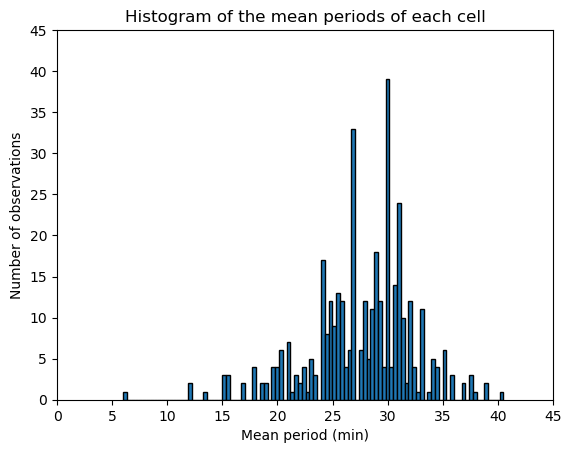

In [114]:
plotter.hist(mean_per[~np.isnan(mean_per)], bins = 100, edgecolor = "k")
plotter.title('Histogram of the mean periods of each cell')
plotter.xlabel('Mean period (min)')
plotter.ylabel('Number of observations')
plotter.axis([0, 45, 0, 45]);

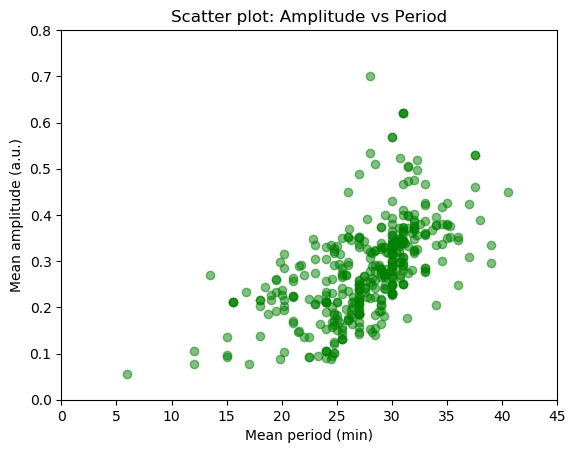

In [115]:
# Because we denoted that there is no period with np.nan,
# in order to represent amplitude vs period we will only
# represent the elements corresponding to a non-nan period.

non_nan_periods = mean_per[~np.isnan(mean_per)]
non_nan_amplitudes = mean_amp[~np.isnan(mean_per)]

plotter.scatter(x = non_nan_periods, 
                y = non_nan_amplitudes, 
                marker = 'o', 
                color = 'g',
                alpha = 0.5)
plotter.title('Scatter plot: Amplitude vs Period')
plotter.xlabel('Mean period (min)')
plotter.ylabel('Mean amplitude (a.u.)')
plotter.axis([0, 45, 0, 0.8]);

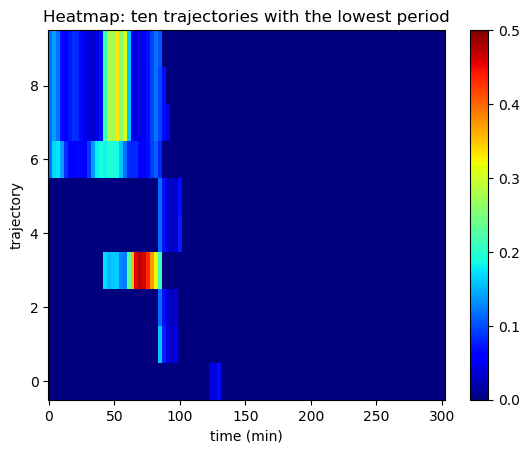

In [131]:
# Selecting the ten cell trajectories with the smallest periods and plot those as a heat map
# Getting the indexes of the ten smallest periods:
lowest_per_indexes = np.argsort(mean_per)[:10]
# Getting the corresponding trajectories
trajectories = x_not_nan[:,lowest_per_indexes]

plotter.imshow(trajectories.T, origin='lower', cmap='jet',
              extent = (-0.5, 3*trajectories.shape[0]-0.5, -0.5, 10-0.5),
              aspect = 'auto')
plotter.colorbar()
plotter.clim(0,0.5)
plotter.title('Heatmap: ten trajectories with the lowest period')
plotter.xlabel('time (min)')
plotter.ylabel('trajectory');


In [ ]:
trajectories_fft = fft(x_not_nan, axis = 0)
# we indicate the axis to perform the fft in the correct axis
xf = 

In [152]:
test_col = np.array([1,3,1,3,1,3,1,3]).reshape(-1,1)

In [156]:
fft(test_col, axis = 0)

array([[16.+0.j],
       [ 0.+0.j],
       [ 0.-0.j],
       [ 0.+0.j],
       [-8.+0.j],
       [ 0.-0.j],
       [ 0.+0.j],
       [ 0.-0.j]])

In [35]:
np.array([1,2,3])[:-1]

array([1, 2])

In [17]:
x[:,35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
plotter.plot(time,x[:,1])


In [29]:
time.shape

(101, 1)

In [13]:
x.shape

(101, 501)

In [ ]:
peaks = find_peaks(x[:,1])

In [ ]:
peaks


In [ ]:
x[:,1]

In [10]:
a=x[:,1]

In [ ]:
a

In [12]:
find_peaks(a)[0]

array([ 6, 17, 27, 37, 44])

In [ ]:
a= x[:,1]
amp=find_peaks(a)[0]
amp == np.nan

amp[amp == np.nan]=0
amp[0]
test=find_peaks(a)

amp[0]

lt={}
lt[0]=amp
lt[1]=amp




In [ ]:

lt

In [ ]:
new_array=lt[1]

In [ ]:
lt[0][0]